In [1]:
import torch
from torch import nn
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

torch.__version__

'2.5.1+cu121'

# Device Agnostic Code

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
device

'cuda'

# Downloading the dataset

In [4]:
#Dataset Download
import requests
import zipfile
from pathlib import Path

# Setup path to a data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
  print(f"{image_path} directory already exists... skipping download")
else:
  print(f"{image_path} does not exist, creating one...")
  image_path.mkdir(parents=True, exist_ok=True)

# Download pizza, steak and suhsi data
with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  print("Downloading pizza, steak, suhsi data...")
  f.write(request.content)

# Unzip pizza, steak, sushi data
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
  print("Unzipping pizza, steak and sushi data...")
  zip_ref.extractall(image_path)

data/pizza_steak_sushi does not exist, creating one...
Unzipping pizza, steak and sushi data...


In [5]:
train_dir = image_path / "train"
test_dir = train_dir = image_path / "test"

# Visualize the dataset for better understanding

Image class: pizza
Image path: data/pizza_steak_sushi/train/pizza/2885050.jpg
Image height: 512
Image width: 512


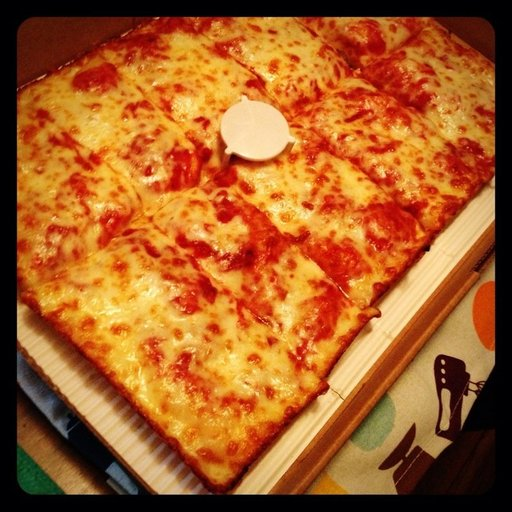

In [6]:
import random
from PIL import Image

torch.manual_seed(42)

image_path_list = list(image_path.glob("*/*/*.jpg"))

random_image_path = random.choice(image_path_list)

image_class = random_image_path.parent.stem

img = Image.open(random_image_path)

print(f"Image class: {image_class}")
print(f"Image path: {random_image_path}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")

img

# Data Preparation

In [7]:
train_transform_augmented = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transform_augmented = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.ToTensor()
])

In [8]:
train_data_augmented = datasets.ImageFolder(root=train_dir,
                                            transform=train_transform_augmented)

test_data_augmented = datasets.ImageFolder(root=test_dir,
                                            transform=test_transform_augmented)

In [9]:
import os

BATCH_SIZE = 32

NUM_WORKERS = os.cpu_count()

torch.manual_seed(42)

train_dataloader =  DataLoader(dataset=train_data_augmented,
                               batch_size=BATCH_SIZE,
                               shuffle=True,
                               num_workers=NUM_WORKERS)

test_dataloader =  DataLoader(dataset=test_data_augmented,
                               batch_size=BATCH_SIZE,
                               shuffle=False,
                               num_workers=NUM_WORKERS)

In [10]:
class_names, class_dict = train_data_augmented.classes, train_data_augmented.class_to_idx

# Model Class

In [11]:
class TinyVGG(nn.Module):
  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape:int):
    super().__init__()

    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, stride=1, padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )

    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*53*53, out_features=output_shape)
    )

  def forward(self, x):
    x = self.conv_block_1(x)
    #print(x.shape) #Imp for in_features calculation
    x = self.conv_block_2(x)
    #print(x.shape) #Imp for in_features calculation.The output height and width to be used in in_features in linear layer
    x = self.classifier(x)
    return x

In [12]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_0 = TinyVGG(input_shape=3, hidden_units=10, output_shape=len(class_names)).to(device)

## Finding the proper in_features for classifier layer

In [13]:
# Do a single forward pass on a single batch
image_batch, label_batch = next(iter(train_dataloader))
image_batch, label_batch = image_batch.to(device), label_batch.to(device)

model_0(image_batch)

tensor([[ 0.0345,  0.0076, -0.0058],
        [ 0.0266,  0.0044,  0.0017],
        [ 0.0346,  0.0055, -0.0047],
        [ 0.0351,  0.0059, -0.0048],
        [ 0.0378,  0.0059, -0.0056],
        [ 0.0406,  0.0062, -0.0041],
        [ 0.0374,  0.0071, -0.0038],
        [ 0.0296,  0.0018, -0.0027],
        [ 0.0386,  0.0036, -0.0041],
        [ 0.0318,  0.0044, -0.0026],
        [ 0.0397,  0.0033, -0.0033],
        [ 0.0333,  0.0005, -0.0056],
        [ 0.0375,  0.0030, -0.0046],
        [ 0.0294,  0.0050, -0.0056],
        [ 0.0416,  0.0014, -0.0036],
        [ 0.0367,  0.0038, -0.0034],
        [ 0.0338,  0.0036, -0.0069],
        [ 0.0381,  0.0019, -0.0035],
        [ 0.0404,  0.0049, -0.0065],
        [ 0.0368,  0.0064, -0.0049],
        [ 0.0348,  0.0068, -0.0020],
        [ 0.0336,  0.0014, -0.0035],
        [ 0.0384,  0.0043, -0.0010],
        [ 0.0357,  0.0049, -0.0066],
        [ 0.0332,  0.0061, -0.0059],
        [ 0.0371,  0.0040, -0.0056],
        [ 0.0420,  0.0040, -0.0077],
 

# Train, Train step, Test step functions

In [14]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer:torch.optim.Optimizer,
               device=device):
  # Put the model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # Loop through data loader data batches
  for batch, (X, y) in enumerate(dataloader):
    # Send data to the target device
    X, y = X.to(device), y.to(device)

    # 1. Forward pass
    y_pred = model(X) # output model logits

    # 2. Calculate the loss
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    # Calculate accuracy metric
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += (y_pred_class==y).sum().item()/len(y_pred)

  # Adjust metrics to get average loss and accuracy per batch
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc

In [15]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device=device):
  # Put model in eval mode
  model.eval()

  # Setup test loss and test accuracy values
  test_loss, test_acc = 0,  0

  # Turn on inference mode
  with torch.inference_mode():
    # Loop through DataLoader batches
    for batch, (X, y) in enumerate(dataloader):
      # Send data to the target device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      test_pred_logits = model(X)

      # 2. Calculate the loss
      loss = loss_fn(test_pred_logits, y)
      test_loss += loss.item()

      # Calculate the accuracy
      test_pred_labels = test_pred_logits.argmax(dim=1)
      test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

  # Adjust metrics to get average loss and accuracy per batch
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc

In [16]:
from tqdm.auto import tqdm

# 1. Create a train function that takes in various model parameters + optimizer + dataloaders + loss function
def train(model: torch.nn.Module,
          train_dataloader,
          test_dataloader,
          optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5,
          device=device):

  # 2. Create empty results dictionary
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}

  # 3. Loop through training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model=model,
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer,
                                       device=device)
    test_loss, test_acc = test_step(model=model,
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn,
                                    device=device)

    # 4. Print out what's happening
    print(f"Epoch: {epoch} | Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f}")

    # 5. Update results dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  # 6. Return the filled results at the end of the epochs
  return results

# Model Training

In [17]:
torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3, # number of color channels of our target images
                  hidden_units=20,
                  output_shape=len(train_data_augmented.classes)).to(device)

In [18]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 10

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(),
                             lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0
model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS,
                        device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 1.2368 | Train acc: 0.2377 | Test loss: 1.0225 | Test acc: 0.5417
Epoch: 1 | Train loss: 1.1191 | Train acc: 0.3523 | Test loss: 1.0963 | Test acc: 0.2604
Epoch: 2 | Train loss: 1.0950 | Train acc: 0.3400 | Test loss: 1.0803 | Test acc: 0.2604
Epoch: 3 | Train loss: 1.0826 | Train acc: 0.3400 | Test loss: 1.0798 | Test acc: 0.2604
Epoch: 4 | Train loss: 1.0835 | Train acc: 0.3797 | Test loss: 1.0611 | Test acc: 0.5975
Epoch: 5 | Train loss: 1.0772 | Train acc: 0.4735 | Test loss: 1.0350 | Test acc: 0.5833
Epoch: 6 | Train loss: 1.0455 | Train acc: 0.4432 | Test loss: 0.9908 | Test acc: 0.5417
Epoch: 7 | Train loss: 1.1023 | Train acc: 0.3627 | Test loss: 0.9453 | Test acc: 0.5521
Epoch: 8 | Train loss: 1.0038 | Train acc: 0.5767 | Test loss: 0.9938 | Test acc: 0.5881
Epoch: 9 | Train loss: 0.9971 | Train acc: 0.4848 | Test loss: 0.9793 | Test acc: 0.4962
Total training time: 10.894 seconds


In [19]:
model_0_results

{'train_loss': [1.2368249495824177,
  1.1190556287765503,
  1.0950119892756145,
  1.0826417207717896,
  1.0834667285283406,
  1.0772143999735515,
  1.0454974174499512,
  1.1022703250249226,
  1.0038074652353923,
  0.9971373279889425],
 'train_acc': [0.23768939393939395,
  0.3522727272727273,
  0.33996212121212127,
  0.33996212121212127,
  0.37973484848484845,
  0.47348484848484845,
  0.4431818181818182,
  0.362689393939394,
  0.5767045454545454,
  0.48484848484848486],
 'test_loss': [1.0225025415420532,
  1.0963006019592285,
  1.0802886883417766,
  1.0798004865646362,
  1.0611443122227986,
  1.0349743962287903,
  0.9908295273780823,
  0.9452767769495646,
  0.9938392043113708,
  0.9792618751525879],
 'test_acc': [0.5416666666666666,
  0.2604166666666667,
  0.2604166666666667,
  0.2604166666666667,
  0.5975378787878788,
  0.5833333333333334,
  0.5416666666666666,
  0.5520833333333334,
  0.5880681818181818,
  0.49621212121212127]}

# Plotting model results

In [20]:
from typing import Tuple, Dict, List
import matplotlib.pyplot as plt

def plot_loss_curves(results: Dict[str, List[float]]):
  """Plots training curves of a results dictionary."""
  # Get the loss values of the results dictionary(training and test)
  loss = results["train_loss"]
  test_loss = results["test_loss"]

  # Get the accuracy values of the results dictionary (training and test)
  accuracy = results["train_acc"]
  test_accuracy = results["test_acc"]

  # Figure out how mnay epochs there were
  epochs = range(len(results["train_loss"]))

  # Setup a plot
  plt.figure(figsize=(15, 7))

  # Plot the loss
  plt.subplot(1, 2, 1)
  plt.plot(epochs, loss, label="train_loss")
  plt.plot(epochs, test_loss, label="test_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # Plot the accuracy
  plt.subplot(1, 2, 2)
  plt.plot(epochs, accuracy, label="train_accuracy")
  plt.plot(epochs, test_accuracy, label="test_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend();

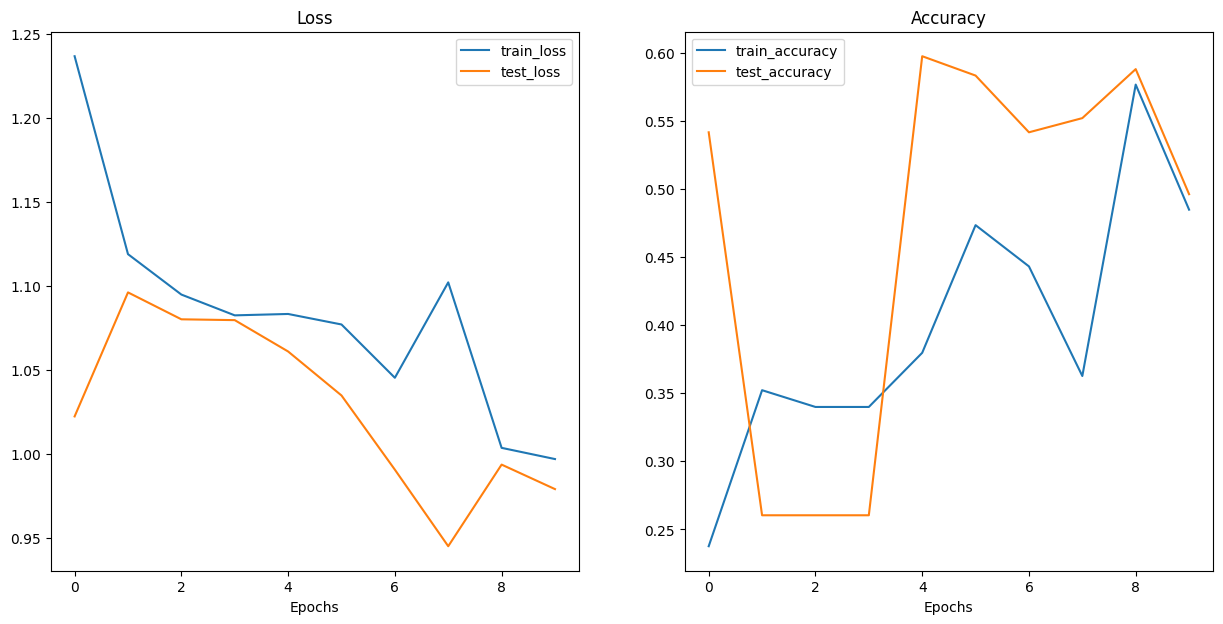

In [21]:
plot_loss_curves(model_0_results)

# Predict on custom image

In [22]:
import requests

custom_image_path = data_path / "04-pizza-dad.jpeg"

if not custom_image_path.is_file():
  with open(custom_image_path, "wb") as f:
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
    print(f"Downloading {custom_image_path}...")
    f.write(request.content)
else:
  print(f"{custom_image_path} already exists, skipping download...")

In [23]:
out_transform = transforms.Compose([
    transforms.Resize(size=(224,224)),
])

In [24]:
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str] = None,
                        transform=None,
                        device=device):
  target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)

  target_image = target_image / 255

  if transform:
    target_image = transform(target_image)

  model.to(device)

  model.eval()
  with torch.inference_mode():
    target_image = target_image.unsqueeze(0)

    target_image_pred = model(target_image.to(device))

  target_image_probs = torch.softmax(target_image_pred, dim=1)
  target_image_labels = target_image_probs.argmax(dim=1)

  plt.imshow(target_image.squeeze().permute(1,2,0))

  if class_names:
    title = f"Pred: {class_names[target_image_labels.cpu()]} | Prob: {target_image_probs.max().cpu():.3f}"
  else:
    title = f"Pred: {target_image_labels} | Prob: {target_image_probs.max().cpu():.3f}"
  plt.title(title)
  plt.axis("off")

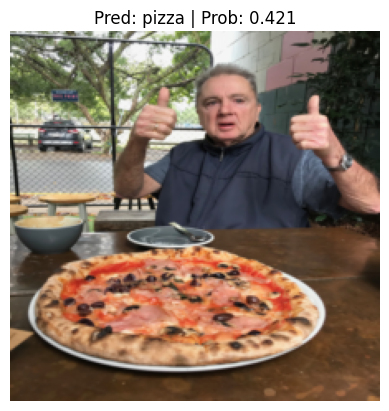

In [25]:
pred_and_plot_image(model_0, custom_image_path, class_names, out_transform, device)

# Save the Model

In [31]:
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "food_classifier_model_0_acc_49%.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

torch.save(obj=model_0.state_dict(),
           f=MODEL_SAVE_PATH)